# Dynamo-scvelo benchmark

Here you will learn the basics of RNA velocity analysis.

For illustration, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. <br/> 
See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) for more details. It can be applied to your own data along the same lines. 

The notebook is also available at
[Google Colab](https://colab.research.google.com/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb)
and [nbviewer](https://nbviewer.jupyter.org/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb).

In [1]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.8.12) on 2021-11-09 13:01.


In [3]:
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
dyn_adata = dyn.sample_data.zebrafish()
print("original data shape:", dyn_adata.shape)
dyn_adata


|-----> Downloading data to ./data/zebrafish.h5ad


original data shape: (4181, 16940)


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

In [4]:
celltype_key = "Cell_type"

In [5]:

preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(dyn_adata) # use monocle as default base config
preprocessor.config_seurat_recipe()
# preprocessor.preprocess_adata_seurat(dyn_adata)

dyn.preprocessing.utils.unique_var_obs_adata(dyn_adata)
preprocessor.filter_genes_by_outliers(dyn_adata, shared_count=20)
preprocessor.normalize_by_cells(dyn_adata, skip_log=True)
preprocessor.select_genes(dyn_adata, recipe="seurat", n_top_genes=2000)
preprocessor.log1p(dyn_adata, layers=["X"])
preprocessor.pca(dyn_adata, pca_key="X_pca")

|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----> rounding mat data
|-----> rounding mat data
|-----> rounding mat data
|-----> size factor normalize following layers: ['unspliced', 'X', 'spliced']
|-----> skipping log transformation as input requires...
|-----> applying None to layer<unspliced>
|-----> <insert> X_unspliced to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> skipping log transformation as input requires...
|-----> applying None to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> skipping log transformation as input requires...
|-----> applying None to layer<spliced>
|-----> <insert> X_spliced to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> filtering genes by dispersion...
|-----> select genes on var key: pass_basic_filter
|-----> select genes by recipe: seurat
|-----------> choose 2000 top genes
|-----

len of mean: (5552,)
shape of subset adata: (4181, 5552)


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

In [6]:
# dyn_adata.layers['spliced']
dyn_adata.layers["spliced"]

<4181x16940 sparse matrix of type '<class 'numpy.int64'>'
	with 4166246 stored elements in Compressed Sparse Row format>

In [7]:
dyn_adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

In [8]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


### Load the Data

## Preprocess by scv.pp

In [9]:
adata = dynamo.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad


### Preprocess the Data by scelo

In [10]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, flavor="seurat")
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11388 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Check if gene subset used for pca are the same

In [11]:
dyn_pca_genes = set(dyn_adata.var_names[dyn_adata.var["use_for_pca"]])
print(len(set(adata.var_names).intersection(dyn_pca_genes)))
assert len(set(adata.var_names).intersection(dyn_pca_genes)) == len(adata.var_names)
assert len(set(adata.var_names).intersection(dyn_pca_genes)) == len(dyn_pca_genes)
print(len(set(adata.var_names).difference(dyn_pca_genes)))
print(len(set(dyn_pca_genes).difference(set(adata.var_names))))
assert len(set(dyn_pca_genes).difference(set(adata.var_names))) == 0
print(len(dyn_pca_genes))
print(adata.n_vars)

2000
0
0
2000
2000


In [12]:
dyn_adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

In [13]:
adata.obs["initial_size"].describe()

count     4181.000000
mean      2922.729736
std       2407.582764
min         68.000000
25%       1252.000000
50%       1984.000000
75%       3843.000000
max      15914.000000
Name: initial_size, dtype: float64

In [14]:
print(adata.obsm["X_pca"].shape)
print(dyn_adata.obsm["X_pca"].shape)

(4181, 30)
(4181, 30)


## Comparison of X_pca, spliced and unspliced data  
Note: scvelo does not log1p transform unspliced and spliced layers/

scvelo seurat X_pca stats:
count    1.254300e+05
mean    -2.070514e-07
std      1.605636e+00
min     -8.343900e+00
25%     -6.412283e-01
50%     -2.956188e-02
75%      5.880693e-01
max      1.131858e+01
dtype: float64
dynamo seurat X_pca stats:


count    1.254300e+05
mean     2.721351e-07
std      1.605636e+00
min     -8.343904e+00
25%     -6.412333e-01
50%     -2.956304e-02
75%      5.880697e-01
max      1.131858e+01
dtype: float64

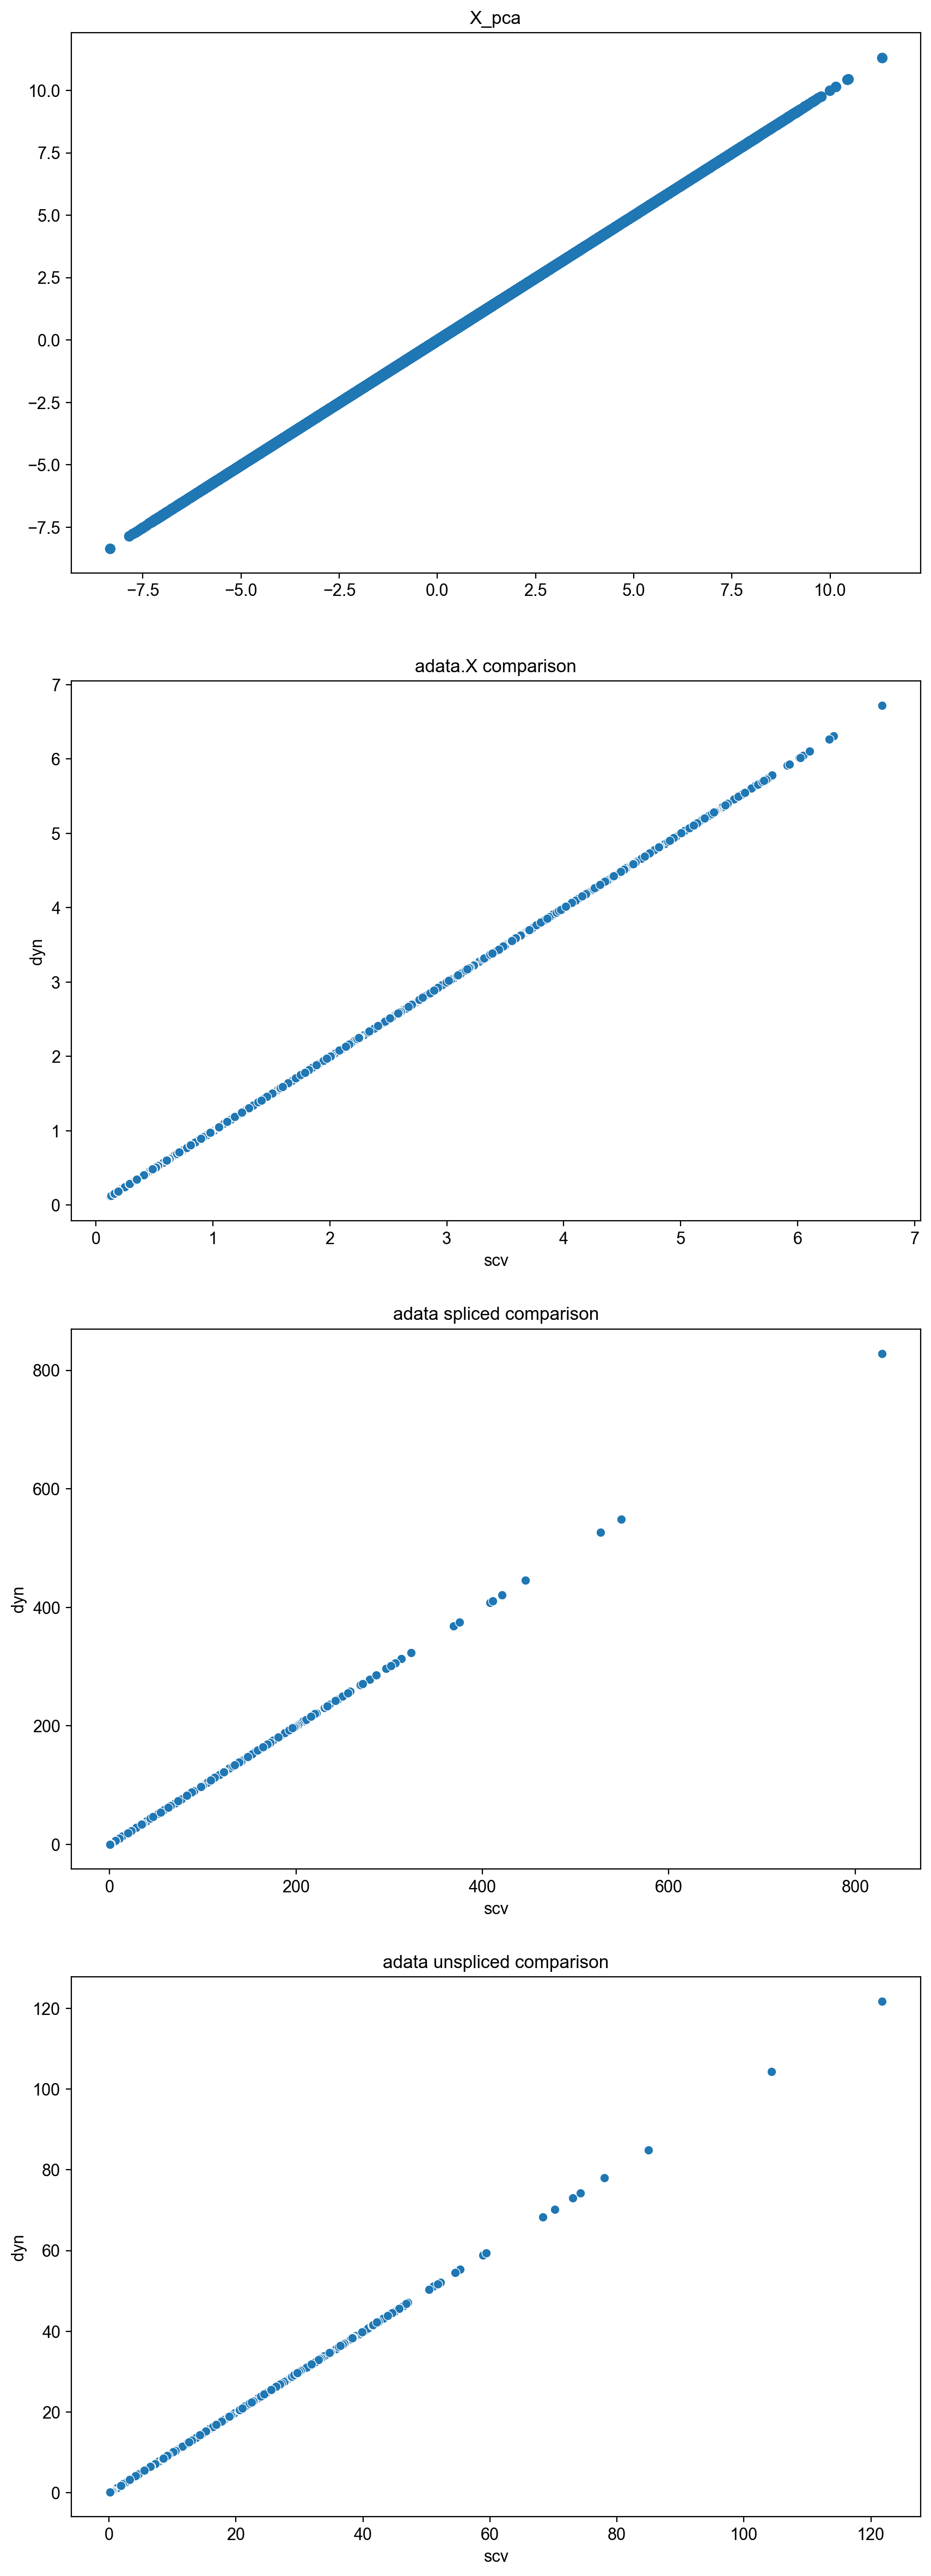

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
fig, axes = plt.subplots(4, figsize=(10, 30))

key = "X_pca"
axes[0].scatter(adata.obsm[key].flatten(), dyn_adata.obsm[key].flatten())#, title="X_pca comparison")
axes[0].set_title(key)
# plot_scatter_sparse(adata.layers["spliced"], dyn_adata.layers["spliced"], ax=axes[1])
# plot_scatter_sparse(adata.layers["unspliced"], dyn_adata.layers["unspliced"], ax=axes[2])
# use_for_pca = dyn_adata.var[DKM.VAR_USE_FOR_PCA]
use_for_pca = list(set(adata.var_names).intersection(dyn_pca_genes))
plot_scatter_sparse(adata[:, use_for_pca].X, dyn_adata[:, use_for_pca].X, ax=axes[1])
axes[1].set_title("adata.X comparison")
axes[1].set_xlabel("scv")
axes[1].set_ylabel("dyn")

plot_scatter_sparse(adata[:, use_for_pca].layers["spliced"], dyn_adata[:, use_for_pca].layers["X_spliced"], ax=axes[2])
axes[2].set_title("adata spliced comparison")
axes[2].set_xlabel("scv")
axes[2].set_ylabel("dyn")
plot_scatter_sparse(adata[:, use_for_pca].layers["unspliced"], dyn_adata[:, use_for_pca].layers["X_unspliced"], ax=axes[3])
axes[3].set_title("adata unspliced comparison")
axes[3].set_xlabel("scv")
axes[3].set_ylabel("dyn")

print("scvelo seurat X_pca stats:")
print(pd.Series(adata.obsm["X_pca"].flatten()).describe())
print("dynamo seurat X_pca stats:")
pd.Series(dyn_adata.obsm["X_pca"].flatten()).describe()

<AxesSubplot:>

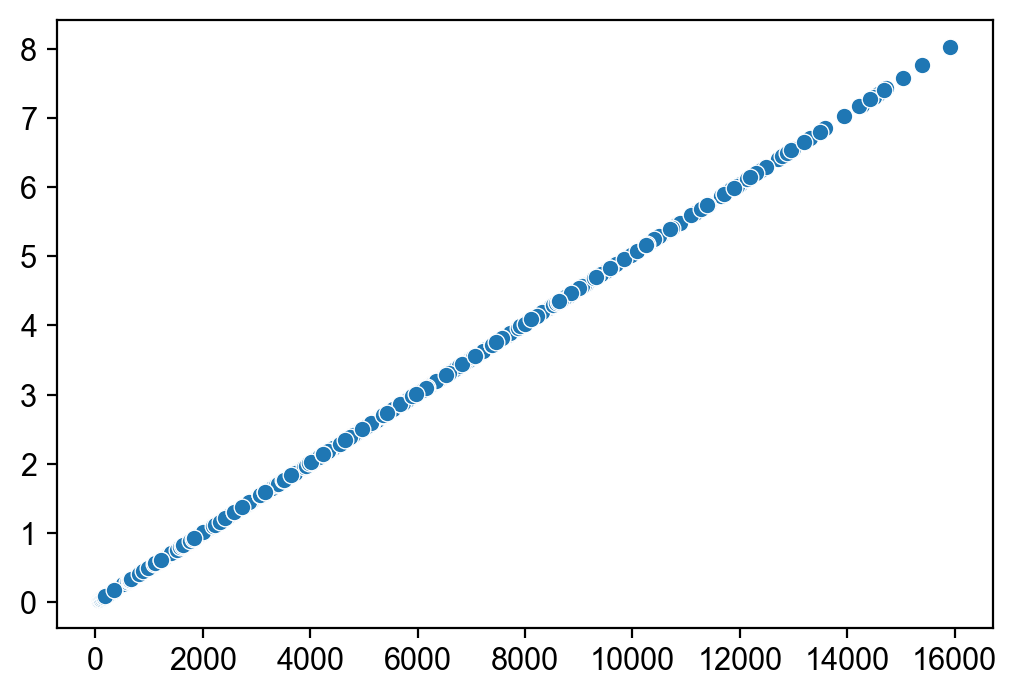

In [16]:
sns.scatterplot(adata.obs["initial_size"].to_numpy(), dyn_adata.obs["Size_Factor"].to_numpy())

<AxesSubplot:>

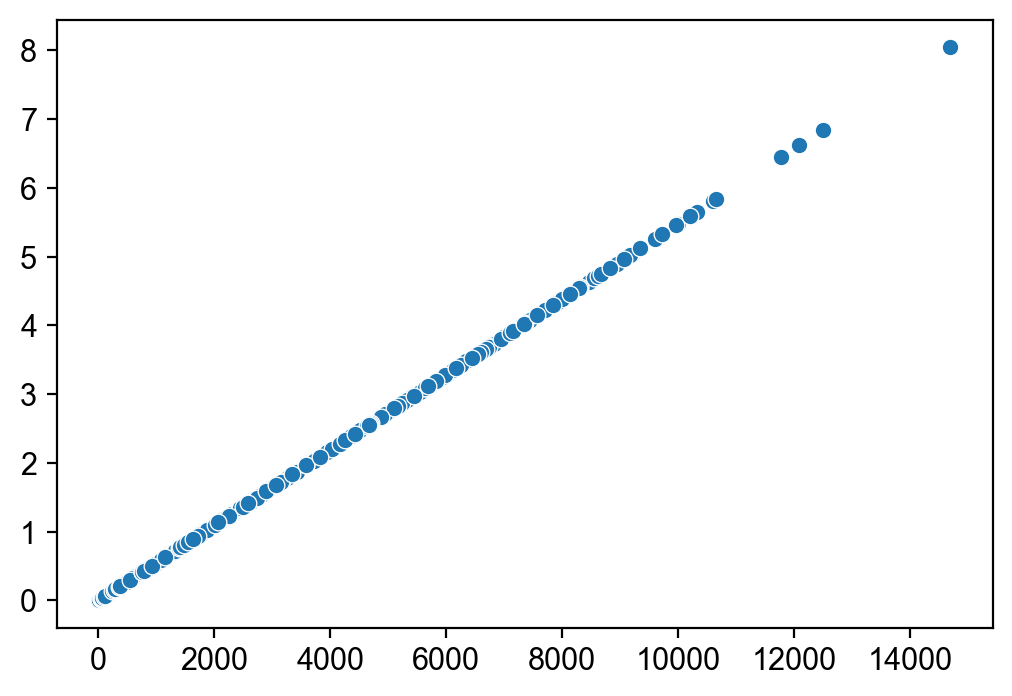

In [17]:
sns.scatterplot(adata.obs["initial_size_unspliced"].to_numpy(), dyn_adata.obs["unspliced_Size_Factor"].to_numpy())

<AxesSubplot:>

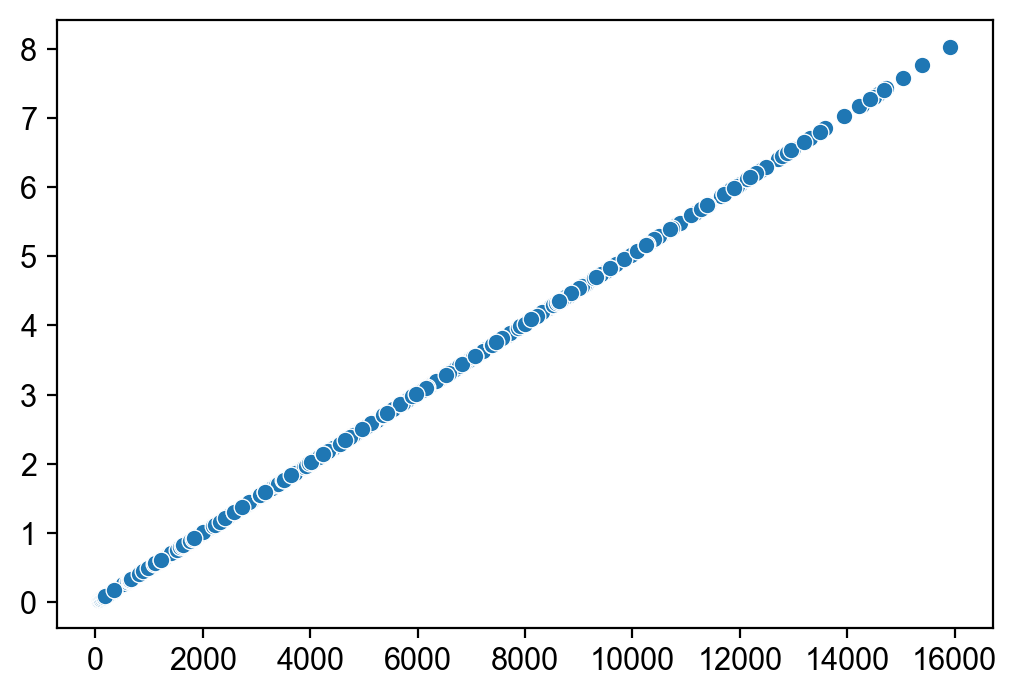

In [18]:
sns.scatterplot(adata.obs["initial_size_spliced"].to_numpy(), dyn_adata.obs["spliced_Size_Factor"].to_numpy())

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [15.2521s]


<Figure size 600x400 with 0 Axes>

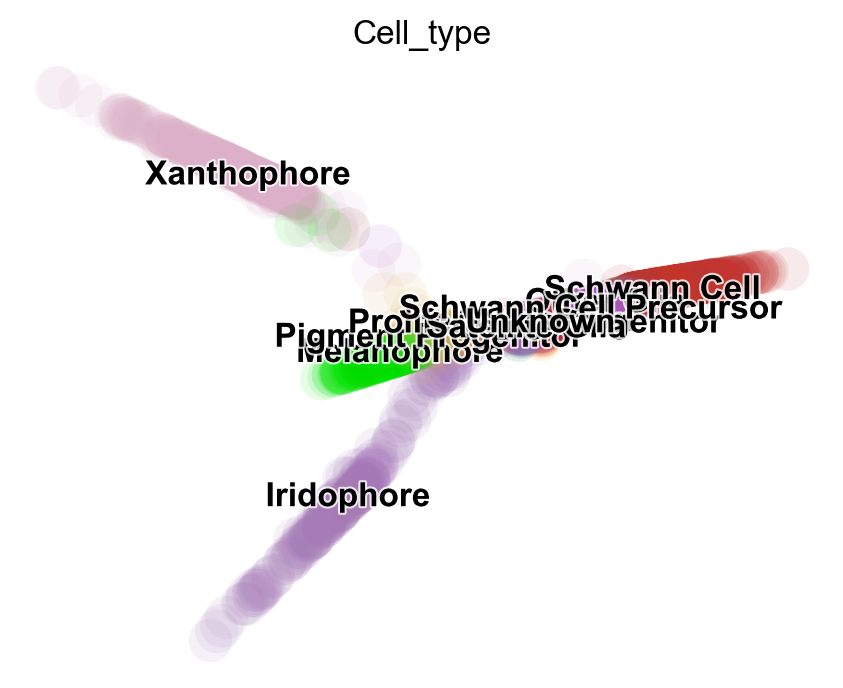

In [19]:
dyn.tl.reduceDimension(dyn_adata)
dyn.pl.umap(dyn_adata, color=celltype_key)

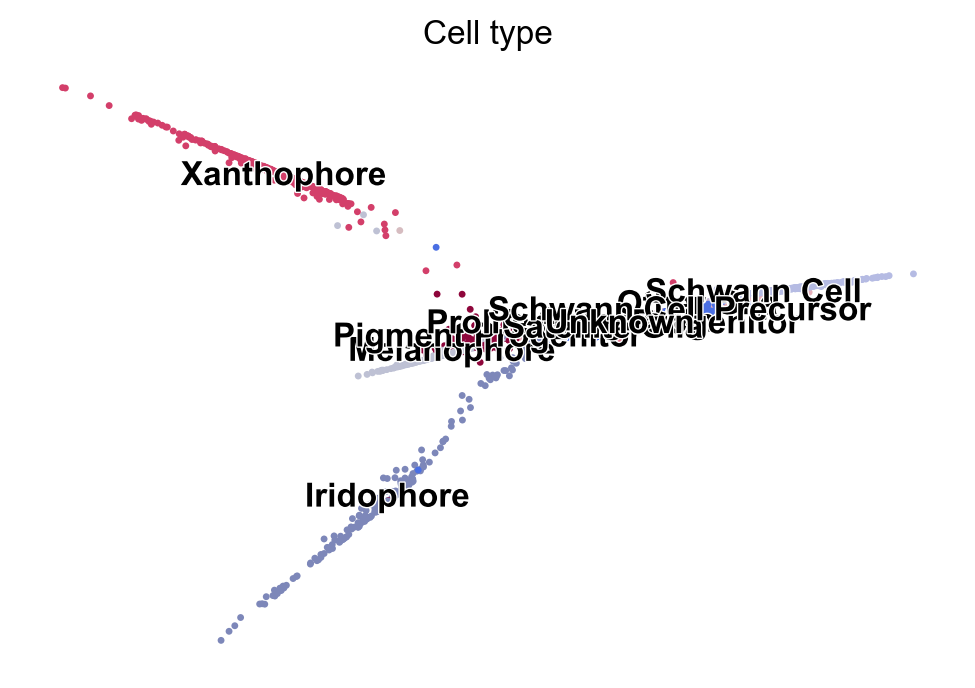

In [20]:
scv.tl.umap(adata)
scv.pl.umap(adata, color=celltype_key)